In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import pygeos

## Load target domain

EPSG:4326


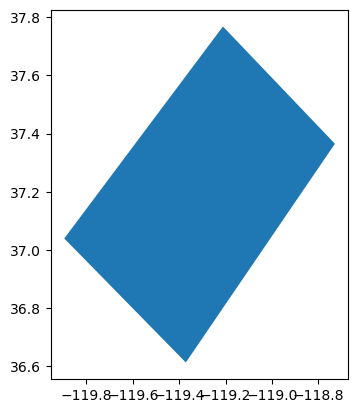

In [2]:
path_to_ca = '/home/adam/cloud/gdrive/fire_project/local_data/ca-state-boundary/CA_State_TIGER2016.shp'
target_domain = gpd.read_file("target_domain_111623.shp")
target_domain.plot()
print(target_domain.crs)

## Load template data

In [3]:
mesh = xr.open_dataset('wrf_CA_unstruct.nc')
mask = xr.open_dataset('oakgrass-strip.nc')

In [4]:
mesh

<xarray.Dataset>
Dimensions:         (origGridRank: 2, nodeCount: 22496, coordDim: 2,
                     elementCount: 22197, maxNodePElement: 4)
Dimensions without coordinates: origGridRank, nodeCount, coordDim,
                                elementCount, maxNodePElement
Data variables:
    origGridDims    (origGridRank) int32 ...
    nodeCoords      (nodeCount, coordDim) float64 ...
    elementConn     (elementCount, maxNodePElement) float64 ...
    numElementConn  (elementCount) int32 ...
    centerCoords    (elementCount, coordDim) float64 ...
    elementArea     (elementCount) float64 ...
    elementMask     (elementCount) int32 ...
Attributes:
    gridType:       unstructured mesh
    version:        0.9
    inputFile:      wrf_CA_scrip.nc
    timeGenerated:  Tue Jun 28 21:52:15 2022

## Explore template data

In [5]:
print(mask.elementCount.values[:5])

[0 1 2 3 4]


In [6]:
[print(key,mask[key].values[0]) for key in list(mask.keys())]

origGridDims 147
nodeCoords [-120.86460876   28.56402874]
elementConn [1. 2. 3. 4.]
numElementConn 4
centerCoords [-120.85491943   28.62024307]
elementArea 1.9724853410590253e-06
elementMask 1


[None, None, None, None, None, None, None]

In [7]:
data_to_map = mask['elementMask'].values
latitude = mask['centerCoords'].values[:,1]
longitude = mask['centerCoords'].values[:,0]

# Template ones and zeros
ones = [d == 1 for d in data_to_map]
zeros = [d != 1 for d in data_to_map]

## Make new mask based on if the coordinates are inside the domain I want to run in

### Create geodataframe of the wrf coordinates

In [8]:
#make spatal object from pixel x y
wrf_points = gpd.points_from_xy(longitude, latitude, z=None, crs="EPSG:4326")

wrf_points_df = pd.DataFrame({'element_count':mask.elementCount.values,'xiulin_mask':mask.elementMask.values,'lat':latitude,'lon':longitude})
wrf_points_df
#create geodataframe

gdf = gpd.GeoDataFrame(wrf_points_df, geometry=wrf_points)

### Create new mask

In [9]:
wrf_points_in_target_domain = gpd.sjoin(gdf, target_domain, predicate='within')

# Select 71 points so that it only uses 2 nodes on Cheyenne
wrf_points_in_target_domain = wrf_points_in_target_domain[:-4]

### Plot template mask and target mask

<Axes: >

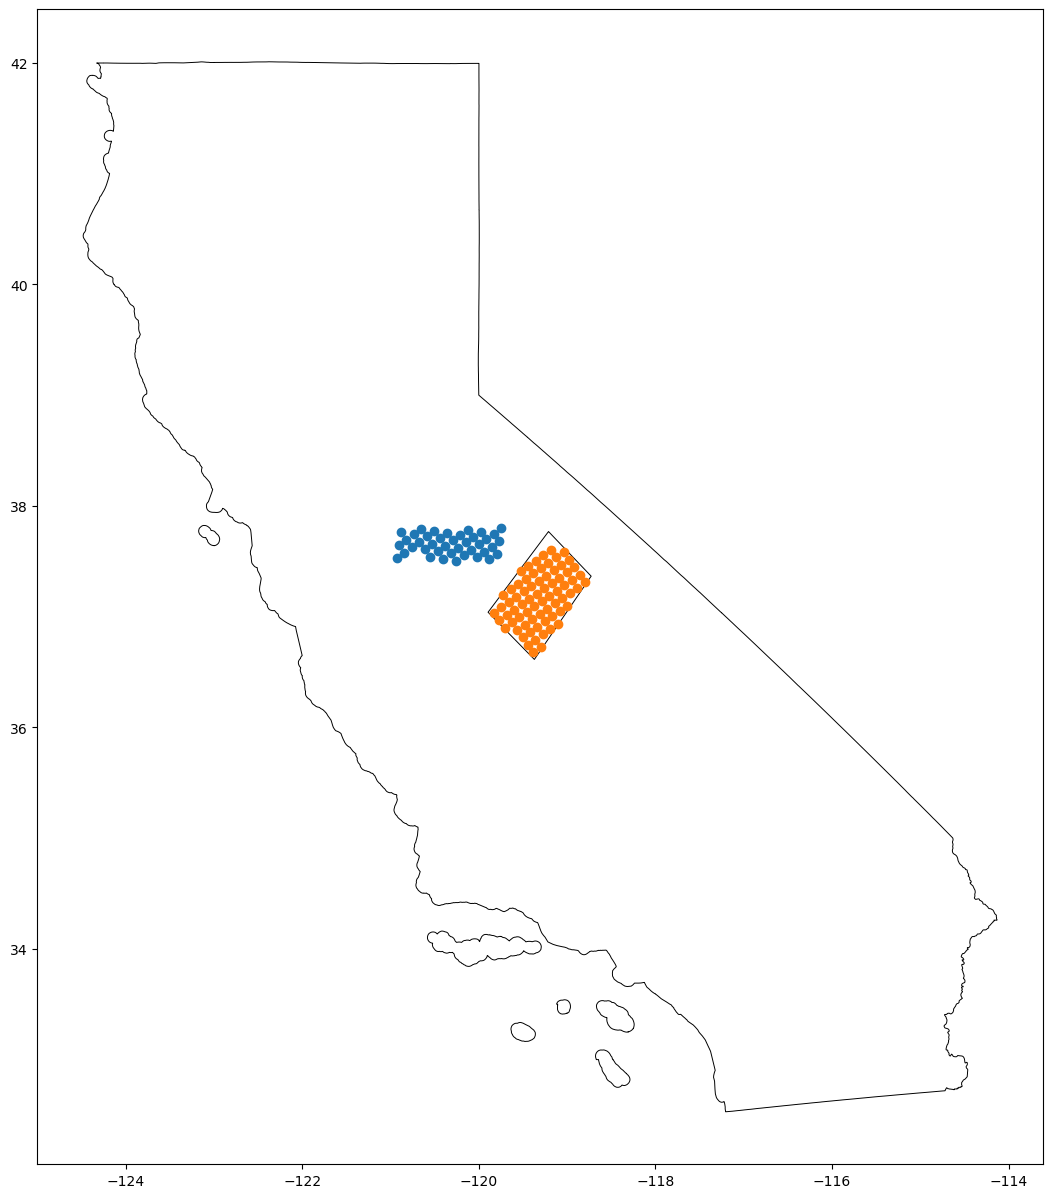

In [10]:
ca = gpd.read_file(path_to_ca).to_crs(target_domain.crs)

fig, ax = plt.subplots(figsize=(15, 15))

# Add california
ca.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)

# Add template mask
gdf.loc[gdf['xiulin_mask'] == 0].plot(ax = ax)

# Add target domain
target_domain.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)

# Add target wrf points
wrf_points_in_target_domain.plot(ax = ax)

### Get indices of mask file that I want to run

In [16]:
target_element_count_vals = list(wrf_points_in_target_domain['element_count'])
target_indices = [el in target_element_count_vals for el in mask.elementCount.values]
np.sum(target_indices)

71

## Create mask where 0 indicates where we want to run FATES

In [17]:
new_mask = np.ones(len(mask.elementCount.values))
new_mask[target_indices] = 0
new_mask

array([1., 1., 1., ..., 1., 1., 1.])

## Put the new mask in a copy of the template mask xarray data array

In [18]:
# Copy into new xarray dataset
new_mask_ds = mask.copy()

# Add new mask data to the dataset
new_mask_ds['elementMask'].values = new_mask

# Write the new mask file to a netcdf file
new_mask_ds.to_netcdf("CZ_mask_111623.nc", format = "NETCDF3_64BIT", mode = "w")

/tmp/ipykernel_5208/2398578088.py:8: SerializationWarning: saving variable elementMask with floating point data as an integer dtype without any _FillValue to use for NaNs
  new_mask_ds.to_netcdf("CZ_mask_111623.nc", format = "NETCDF3_64BIT", mode = "w")


In [19]:
points_in = [el == 0 for el in new_mask_ds['elementMask'].values]

In [20]:
new_mask_ds['centerCoords'].values[points_in,:]

array([[-119.38523865,   36.67720413],
       [-119.30090332,   36.72508621],
       [-119.4450531 ,   36.74477768],
       [-119.360672  ,   36.79272461],
       [-119.27618408,   36.84059906],
       [-119.19155884,   36.8884201 ],
       [-119.10681152,   36.93617249],
       [-119.50498962,   36.81232834],
       [-119.420578  ,   36.86032867],
       [-119.33602905,   36.90826797],
       [-119.25135803,   36.95614243],
       [-119.16656494,   37.00394821],
       [-119.08163452,   37.05168533],
       [-118.99659729,   37.0993576 ],
       [-119.56506348,   36.87984467],
       [-119.48059082,   36.92790604],
       [-119.39599609,   36.97589874],
       [-119.3112793 ,   37.02383804],
       [-119.22645569,   37.07170105],
       [-119.14147949,   37.11949921],
       [-119.05638123,   37.16722488],
       [-118.97116089,   37.21489716],
       [-118.88580322,   37.26249313],
       [-118.80032349,   37.31002808],
       [-119.70962524,   36.89916229],
       [-119.62524414,   

In [23]:
np.min(new_mask_ds['centerCoords'].values[points_in,0])

-119.83047485351562